## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [4]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [5]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data
There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?
4. Do you think that it is a good idea to use a PCA before the NMF algorithm? Why?

**Answer**

2. The basis images with NNMF are bright only on a small part of the face, and dark elsewhere. It is because with NNMF each observation is a purely additive combination of the basis vectors (eigenfaces).

3. The accuracy of NNMF is better than PCA and ICA : the best percentage of correct answer with PCA or ICA was around 0.74. NNMF is known to be robust to the noise, so it may explained the better results.

4. Using PCA before NNMF could help with computational time, by reducing the dimensionality. 

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


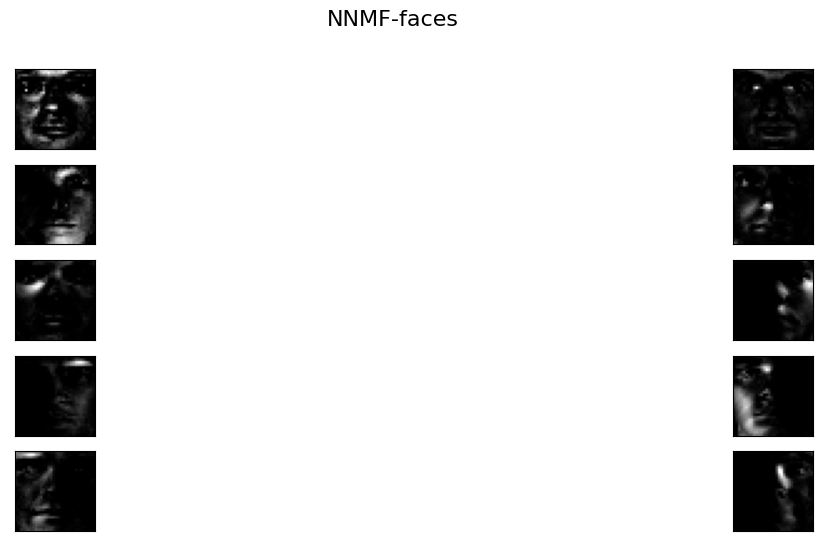

In [3]:
# NNMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [3]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W=np.random.rand(d,r)
    H=np.random.rand(r,N)
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            W = np.divide(np.multiply(W, XH), W@HH + eps)
                       
        H = np.divide(np.multiply(H, W.T@X), W.T@W@H + eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

Iteration NNMF number  1  out of  300 , delta =  0.5303549315704322 , error (norm delta):  273.0038485438691
Iteration NNMF number  100  out of  300 , delta =  0.15838943557966825 , error (norm delta):  81.53205128855896
Iteration NNMF number  200  out of  300 , delta =  0.15076918335060296 , error (norm delta):  77.60947404533492
Iteration NNMF number  300  out of  300 , delta =  0.1483178246569144 , error (norm delta):  76.34762029853032
Maximum number of iterations reached ! delta =  0.1483178246569144


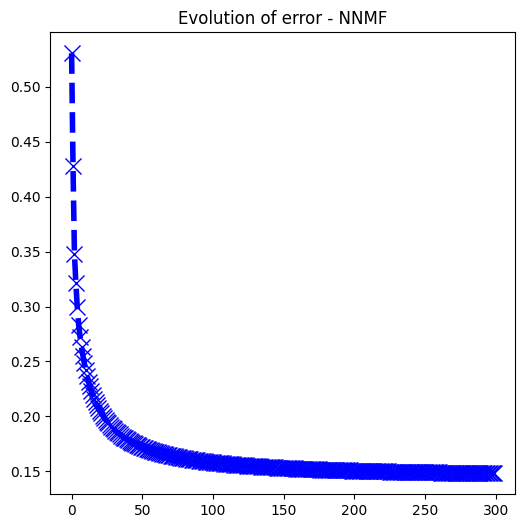

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8592132505175983


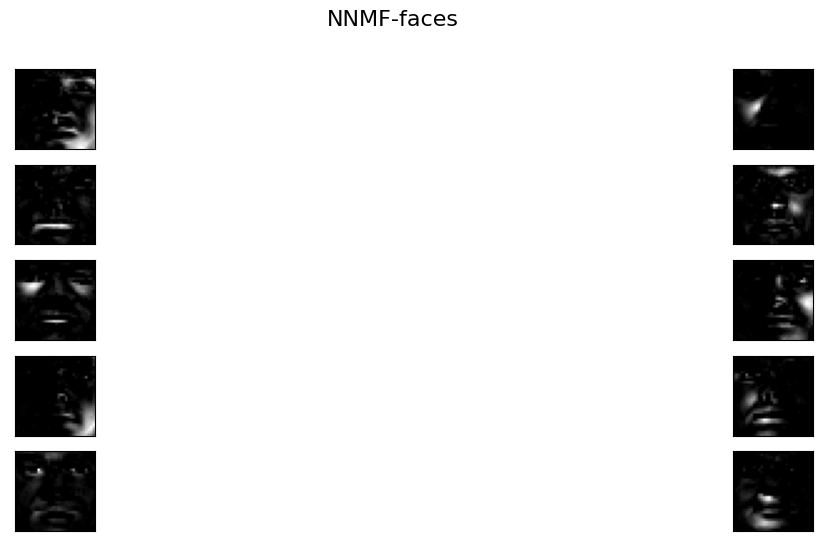

In [5]:
# NNMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

- What do you observe?
- What is the limitation of doing an inversion for Htest_nnmf? How would you avoid that?

**Answer**

- We get eigenfaces that look very similar to the ones we got using scickit implementation of NNMF, and we get the same percentage of accuracy. Our implementation works.

- First, we use a pseudo-inverse for the computation of Htest_nnmf (since W isn't a square matrix). Moreover, given $X = WH + \mathcal{N}$, $\mathcal{N}$ being a noise (we assume Gaussian), there is an error $W^+\mathcal{N}$ on the computation of $H$.

## I-3) ICA and NNMF in the presence of noise

We will now compare ICA and NNMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NNMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NNMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NNMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NNMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NNMF are used as pre-processing steps. Comment your results.

**Answer**

1. A Gaussian noise might add some correlation between the components of the ICA. The ICA would then behave wrongly, because it is based on the assumption that all components are statiscally independent.

2. NNMF might behave better with the addition of Gaussian noise, because it makes no assumption on the data.

In [14]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation
    XtrainNoise = Xctrain + np.random.normal(0,sigmaTab[i], size=Xctrain.shape)
    XtestNoise = Xctest + np.random.normal(0,sigmaTab[i], size=Xctest.shape)
    
    XtrainNoise = np.maximum(XtrainNoise, 0)
    XtestNoise = np.maximum(XtestNoise, 0)
    ##################
    # NMF
    Ncomponents=250
    
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T,Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T,Id_Test)

    ##################
    ## ICA
    # Apply ICA
    ICA= FastICA(n_components=Ncomponents, whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
    Yica=ICA.fit_transform(XtrainNoise)
    Wica=ICA.mixing_
    
    Ytest = ICA.transform(XtestNoise)
    
    Y_test_ICA = Wica @ Ytest.T
    Y_train_ICA = Wica @ Yica.T

    # Score
    NN.fit(Y_train_ICA.T,Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(Y_test_ICA.T,Id_Test.ravel()))
    scoreICA[i] = NN.score(Y_test_ICA.T,Id_Test.ravel())

NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8260869565217391
Percentage of correct answer using ICA is  0.7287784679089027
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8219461697722568
Percentage of correct answer using ICA is  0.7122153209109731
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.7556935817805382
Percentage of correct answer using ICA is  0.6749482401656315
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.6045548654244306
Percentage of correct answer using ICA is  0.6252587991718427
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.42650103519668736
Percentage of correct answer using ICA is  0.5486542443064182
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.2401656314699793
Percentage of correct answer using ICA is  0.44306418219461696
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.15320910973084886
Percentag

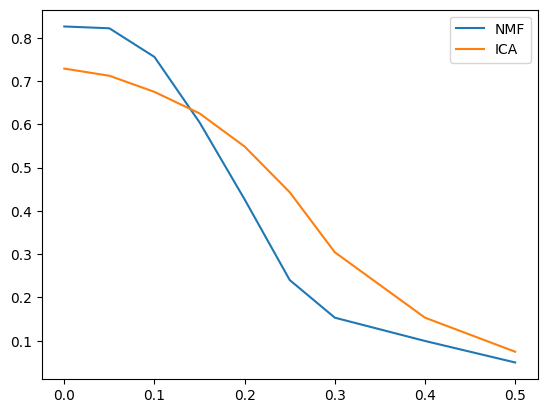

In [16]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [6]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

(700, 2)


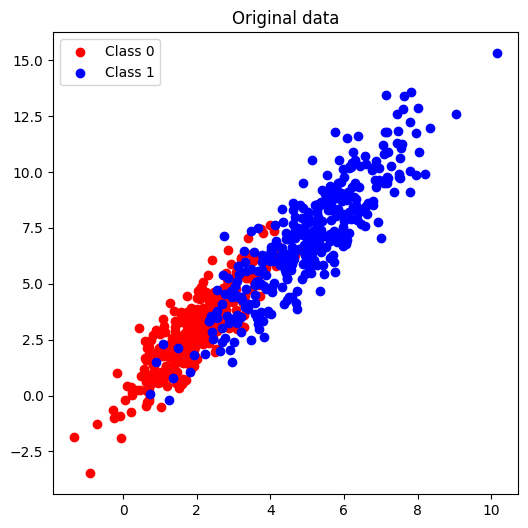

In [70]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

print(X.shape)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?

**Answer**

1. The result is exact only with the first scenario. As soon as both classes start overlapping, KMeans is wrong. Since we know the classes we want beforehand, it is easy in our case to define the number of clusters, but I would have far more difficult without such knowledge about our data.

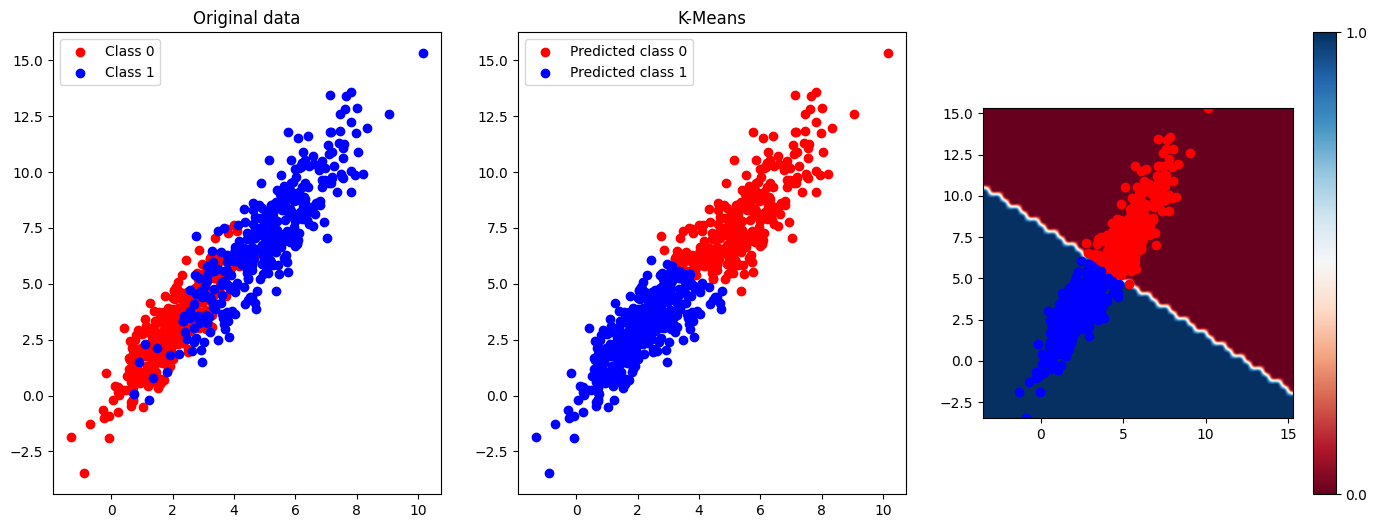

In [71]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

Now, implement your own K-means using the Lloyd's algorithm.

In [66]:
def KMeansLecture(X,K=2,tol=1e-4):
    N, d = X.shape
    muTab = [X[np.random.randint(N)] for k in range(K)]
    yKMeans = np.ones((N,K))
    yKMeans_new = np.zeros((N,K))
    it = 0
    while np.sum(np.abs(yKMeans - yKMeans_new)) > tol:
        yKMeans = yKMeans_new.copy()
        yKMeans_new = np.zeros((N,K))
        for idx, x in enumerate(X):
            min_dist = np.inf
            min_k = 0
            for k, mu in enumerate(muTab):
                dist = np.linalg.norm(x-mu)
                if dist < min_dist:
                    min_dist = dist
                    min_k = k
            yKMeans_new[idx][min_k] = 1
            
        muTab = [np.average(X, axis=0, weights=yKMeans_new[:,k]) for k in range(K)]
        it += 1
        
    yKMeans = yKMeans_new.copy()           
    return yKmeans,muTab

Now, test your K-means algorithm.

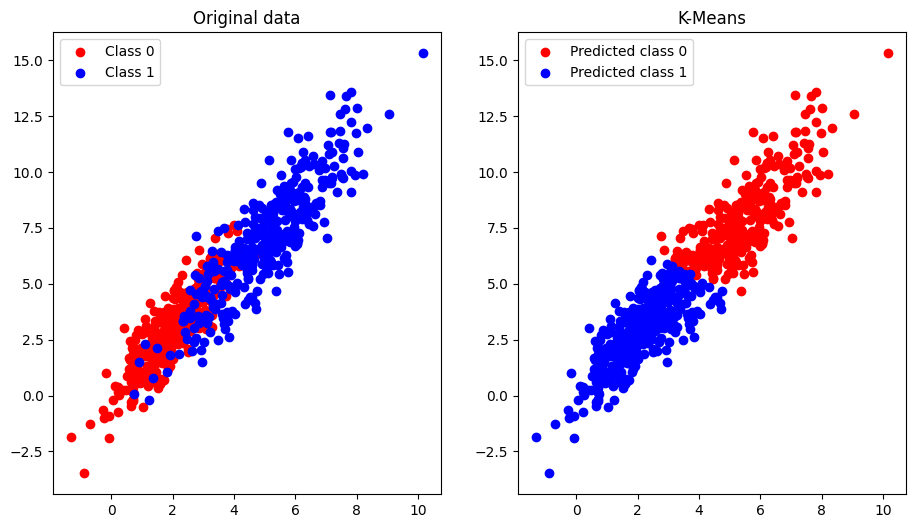

In [72]:
## K-means
Ncluster= 2 # choose a number of clusters
yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


C:\Users\Antoine\AppData\Local\Temp\ipykernel_9552\2387266696.py:26: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
C:\Users\Antoine\AppData\Local\Temp\ipykernel_9552\2387266696.py:37: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)


(-0.5, 374.5, 280.5, -0.5)

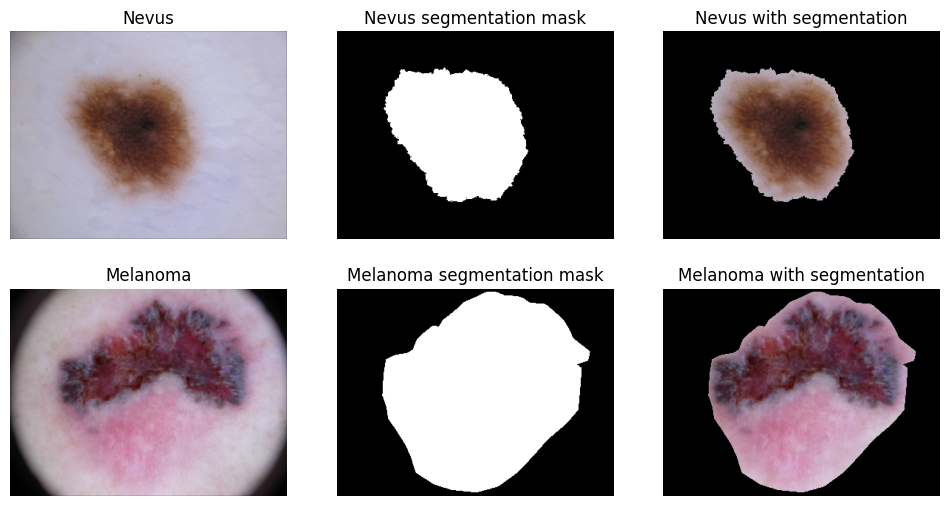

In [75]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./" 




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpeg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. Propose a way to automatically select the class (or unions of classes) representing the skin lesion and not the skin. (You don't need to implement it, just explain how you would do it).

4. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

**Answers**

1. Ideally, we would look for two classes : Skin and Lesion. I would rather use 4 classes for the second image because in the image we can se that there are a black background, healthy skin, red/irritated skin and the lesion.

2. We get the best score for Nevus segmentation with two clusters on the blue channel. This isn't surprising since the lesion and the healthy skin are clearly separated in the image. On the other hand, we get a surprising result with the melanoma : the best result is obtained with only two clusters on the green channel. This may be because no matter how much clusters (from two to four), we get poor results. The "best" number of clusters we found might not be relevant.

3. On the images, the Lesion class always ressemble a circle in the middle of the image. We could use that to label the region corresponding to the lesion after KMeans. For example, we could check wether the class is convex or not : if not it, there is a high it represents the healthy skin. If we have several eligible classes, we could merge them into one, if they are close enough to each other (like it is the case in the melanoma image, with the classes red/irritated skin and the lesion).

4. After having computated the average for a class, we could use change its value to the one its nearest neighbor in the class, so that the average is always one of the original observation.

The dice score is  0.82970843714228


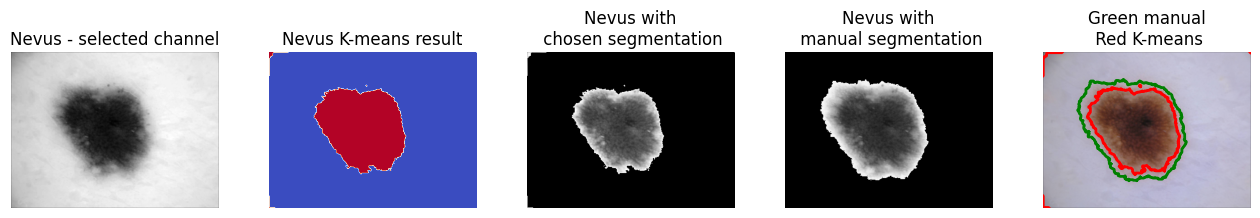

In [93]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1)[0], mask.reshape(1,-1)[0]))

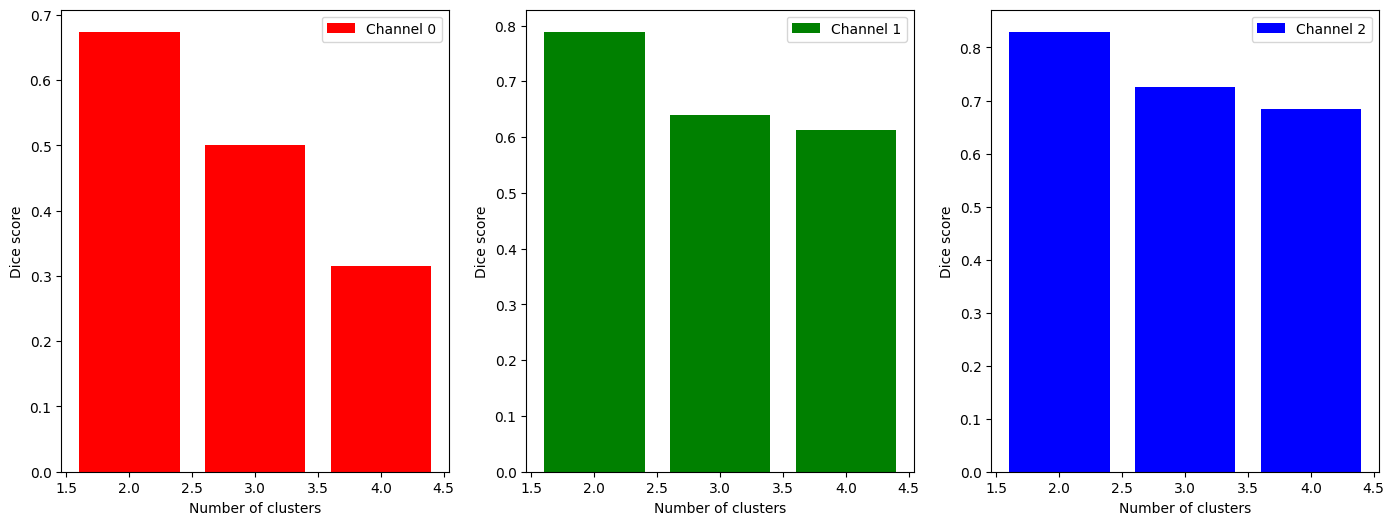

In [107]:
diceTab_nevus = []

for channel in [0,1,2]:
    dice_channel = []
    for K in [2,3,4]:
        
        # Select a channel (0 for Red, 1 for Green and 2 for Blue)
        nevusB = nevus[:,:,channel] 

        # Select the number of cluster K to look for 
        kmeans=KMeans(n_clusters=K, random_state=1) 
        labels=kmeans.fit_predict(nevusB.reshape(-1,1))
        labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        index =1
        mask=labels==index ## choose which label should be
        
        dice_channel.append(1-dice(nevusMask_boolean.reshape(1,-1)[0], mask.reshape(1,-1)[0]))
    diceTab_nevus.append(dice_channel)
        
plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.bar([2,3,4],diceTab_nevus[0], color='r', label='Channel 0')
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.legend()
plt.subplot(132)
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.bar([2,3,4],diceTab_nevus[1], color='g', label='Channel 1')
plt.legend()
plt.subplot(133)
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.bar([2,3,4],diceTab_nevus[2], color='b', label='Channel 2')
plt.legend()

The dice score is  0.01314426314426309


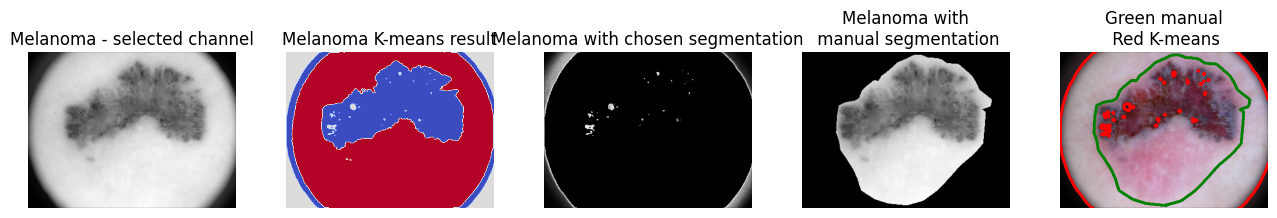

In [106]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0
##
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1)[0], mask.reshape(1,-1)[0]))

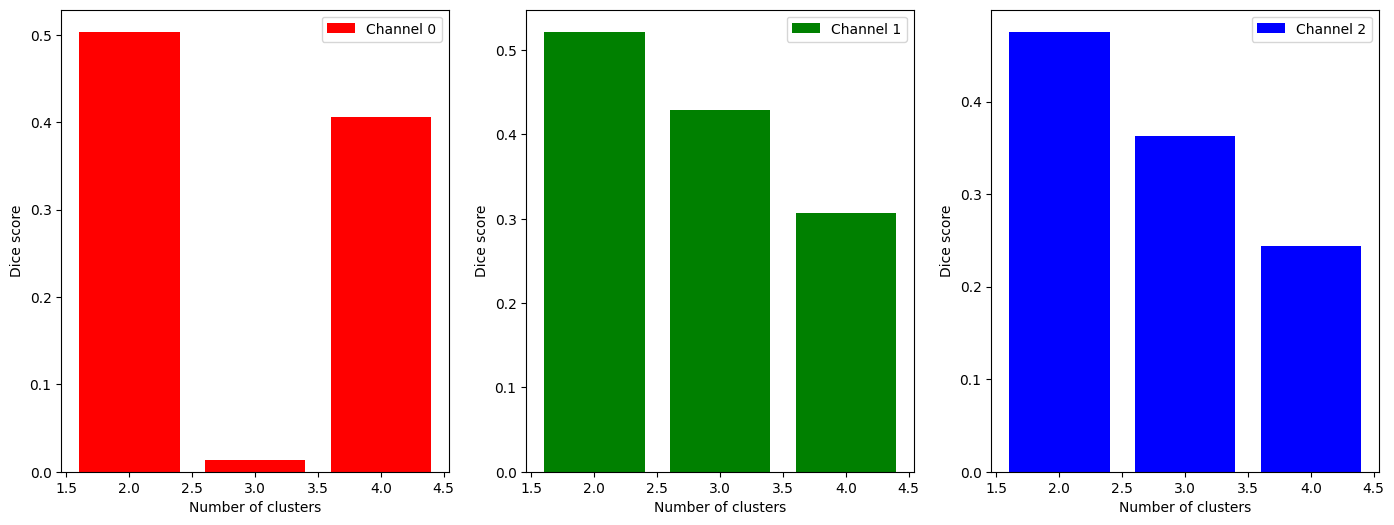

In [108]:
diceTab_melanoma = []

for channel in [0,1,2]:
    dice_channel = []
    for K in [2,3,4]:
        
        # Select a channel (0 for Red, 1 for Green and 2 for Blue)
        melanomaB = melanoma[:,:,channel]

        # Select the number of cluster K to look for 
        kmeans=KMeans(n_clusters=K) 
        labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
        labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

        # Depending on the number of classes K, K-means returns one integer per pixel 
        # which indicates the number of the cluster. 
        # Choose the integer to use as mask between 0 and K-1
        index =1
        mask=labels==index ## choose which label should be
        
        dice_channel.append(1-dice(melanomaMask_boolean.reshape(1,-1)[0], mask.reshape(1,-1)[0]))
    diceTab_melanoma.append(dice_channel)
        
plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.bar([2,3,4],diceTab_melanoma[0], color='r', label='Channel 0')
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.legend()
plt.subplot(132)
plt.bar([2,3,4],diceTab_melanoma[1], color='g', label='Channel 1')
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.legend()
plt.subplot(133)
plt.bar([2,3,4],diceTab_melanoma[2], color='b', label='Channel 2')
plt.ylabel("Dice score")
plt.xlabel("Number of clusters")
plt.legend()